_Import the necessary libraries_

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
try:
    df =\
    pd.read_excel(
        "/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignments/Assignment 1/Industry_Portfolios.xlsx"
    )
except FileNotFoundError:
    print("check path")
    
df.drop("Date", axis=1, inplace=True)

/Users/gabriel/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Formulas Used:

#### Scalars:

- $\alpha=R^{\prime} V^{-1} e$
- $\zeta=R^{\prime} V^{-1} R$
- $\delta=e^{\prime} V^{-1} e$


#### Portfolio Risk:

$
\sigma_p^2=\frac{1}{\delta}+\frac{\delta}{\zeta \delta-\alpha^2}\left(R_P-R_{m v}\right)^2
$


## Define functions

In [5]:
def required_inputs(df):
    mean = df.mean()
    std = df.std()
    covm = df.cov()
    e = np.ones(mean.shape)
    covm_inv = np.linalg.inv(covm)
    
    return mean, std, covm, e, covm_inv

def greeks(mean, covm_inv, e):
    alpha = np.dot(mean.T, np.dot(covm_inv, e))
    zeta = np.dot(mean.T, np.dot(covm_inv, mean))
    delta = np.dot(e.T, np.dot(covm_inv, e))

    return alpha, zeta, delta

def weight_starred(alpha, zeta, delta, mean, covm_inv, e):
    # numerator_1 = (zeta - alpha * mean) * np.dot(covm_inv, e)
    term1 = ((delta * mean - alpha) / (zeta * delta - alpha ** 2)) * np.dot(covm_inv, mean)
    term2 = ((zeta - alpha * mean) / (zeta * delta - alpha ** 2)) * np.dot(covm_inv, e)
    w = term1 + term2
    #Force it down? 
    w /= np.sum(w)
    
    return term1, term2, w

def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

def portfolio_ret(weights, returns):
    return np.dot(weights.T, returns)

In [99]:
def mvf(df, ystart, yend, iter, rf):
    #Getting the inputs ready
    mean_ret = df.mean()
    std = df.std()
    covm = df.cov()
    e = np.ones(mean_ret.shape)
    covm_inv = np.linalg.inv(covm)
    
    #Calculating the greeks
    alpha = np.dot(mean_ret.T, np.dot(covm_inv, e))
    zeta = np.dot(mean_ret.T, np.dot(covm_inv, mean_ret))
    delta = np.dot(e.T, np.dot(covm_inv, e))
    ret_mv = alpha / delta
    
    #Creating the return and risk vector
    ret1 = np.linspace(start=0, stop=yend, num=iter)
    var1 = (1 / delta) + (delta / (zeta * delta - alpha ** 2 )) * (ret1 - ret_mv) ** 2
    sigma1 = np.sqrt(var1)
    
    #Fill out the dataframe
    mvf1 = pd.DataFrame(ret1, columns = ["rets"])
    mvf1["sigma1"] = sigma1
    
    #With Riskless Asset
    ret2 = np.linspace(start=ystart, stop=yend, num=iter)
    sigma2 = np.sqrt((ret2 - rf) ** 2 / 
             (zeta - 2 * alpha * rf + delta * rf ** 2))
    
    mvf2 = pd.DataFrame(ret2, columns = ['rets_wra'])
    mvf2['sigma2'] = sigma2
    
    #Tangency Portfolio
    ret_tg = ret_mv - ((zeta * delta - alpha ** 2) / (delta ** 2 * (rf - ret_mv)))
    a = (zeta * covm_inv @ e - alpha * covm_inv @ mean_ret) / (zeta * delta - alpha ** 2)
    b = (delta * covm_inv @ mean_ret - 
         alpha * covm_inv @ e) / (zeta * delta - alpha ** 2)
    weight_tg = a + b * ret_tg
    rp_tg = ret_tg - rf
    sigma_tg = -(zeta - 2*alpha*rf + delta *rf**2)**(1/2) / (delta *(rf - ret_mv))
    sharpe_tg = rp_tg / sigma_tg

    var_vector = [covm.iloc[i,i] for i in range(len(mean_ret.index))]
    table = pd.DataFrame(mean_ret, 
                         index = mean_ret.index, 
                         columns = ['Mean Returns'])
    table['SD of Returns'] = np.sqrt(var_vector)
    table['Weight Tangency'] = weight_tg
    table = table.round(2)
    
    print('Risk premium for tangency portfolio: ', round(rp_tg, 2))
    print('Sharpe ratio for tangency portfolio: ', round(sharpe_tg, 2))
    
    return mvf1, mvf2, table, rp_tg, ret_tg, sigma_tg

In [103]:
def plotmvf(mvf1, mvf2, ret_tg, sigma_tg):
    
    #Setting up
    plt.figure(figsize=(12, 9))
    plt.ylabel("Mean Return (%)")
    plt.xlabel("Portfolio Risk (%)")
    plt.title("Minimum-Variance Frontier w/o risk-free asset")
    plt.grid(True)
    plt.ylim(0, 2)
    plt.yticks(np.arange(0, 2.2, 0.1))
    
    # Slice the information for X and Y data
    plt.plot(mvf1.loc[:, "sigma1"], mvf1.loc[:, "rets"], "g-") 
    plt.show()
    
    #Setting up
    plt.figure(figsize=(12, 9))
    plt.ylabel("Mean Return (%)")
    plt.xlabel("Portfolio Risk (%)")
    plt.title("Minimum-Variance Frontier w/ risk-free asset")
    plt.grid(True)
    plt.ylim(0, 2)
    plt.yticks(np.arange(0, 2.2, 0.1))
    
    # Slice the information for X and Y data
    plt.plot(mvf2.loc[:, "sigma2"], mvf2.loc[:, "rets_wra"], "r-") 
    plt.show()
    
    #Combined
    plt.figure(figsize=(12, 9))
    plt.ylabel("Mean Return (%)")
    plt.xlabel("Portfolio Risk (%)")
    plt.title("Minimum-Variance Frontier Combined")
    plt.grid(True)
    plt.plot(mvf1.loc[:, "sigma1"], mvf1.loc[:, "rets"], "g-", label="Without Riskless Asset", zorder=1) 
    plt.plot(mvf2.loc[:, "sigma2"], mvf2.loc[:, "rets_wra"], "r-", label="With Riskless Asset", zorder=1)
    plt.scatter(sigma_tg, ret_tg, marker="+", color="y", s=300, zorder=2)
    plt.ylim(0, 2)
    plt.yticks(np.arange(0, 2.2, 0.1))
    plt.legend(loc="upper left")
    plt.show()
    

_Create a table showing the mean return and standard deviation of return for the ten industry portfolios._

Risk premium for tangency portfolio:  1.36
Sharpe ratio for tangency portfolio:  0.4


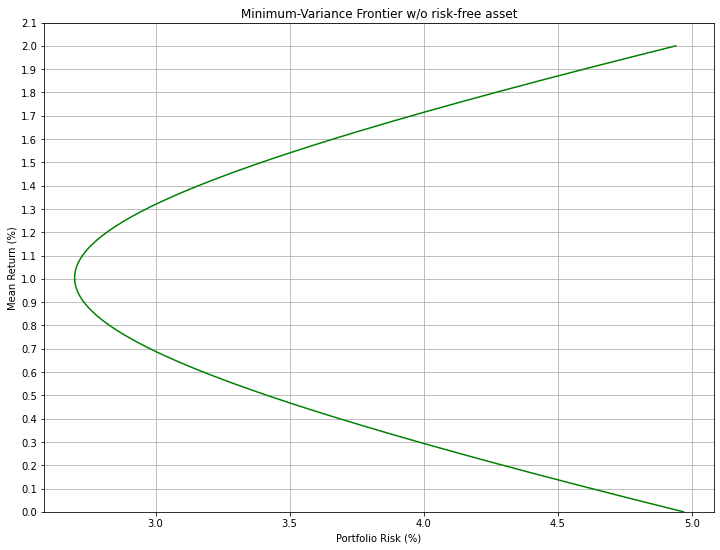

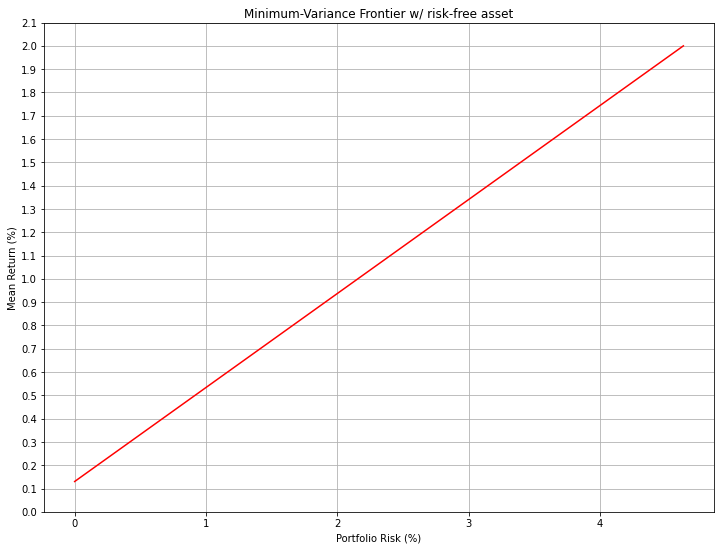

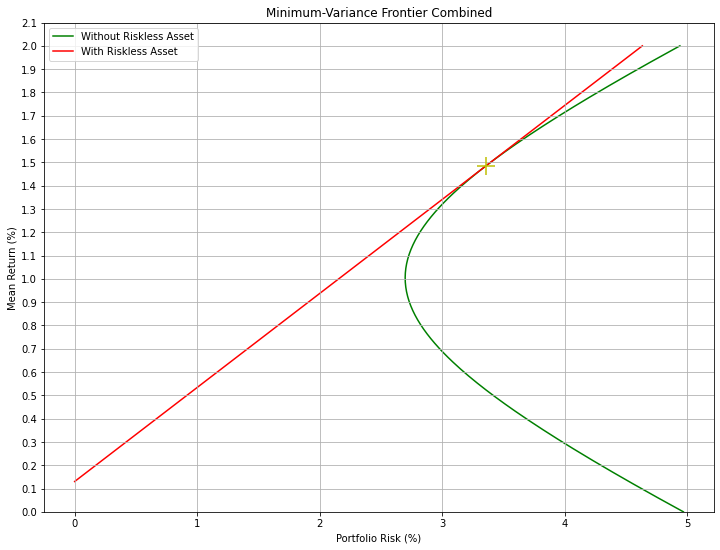

       Mean Returns  SD of Returns  Weight Tangency
NoDur          0.90           3.35             0.57
Durbl          0.73           8.36            -0.21
Manuf          1.01           5.31             0.71
Enrgy          1.23           6.08             0.10
HiTec          0.77           5.38            -0.36
Telcm          0.88           4.45            -0.10
Shops          0.92           4.09             0.99
Hlth           0.78           3.79             0.08
Utils          0.91           3.70             0.13
Other          0.49           5.58            -0.91
Sum of portfolio weights: 1.0
Risk Premium (Tangency) 1.36
Return (Tangency) 1.49
Standard Deviation (Tangency) 3.36


In [104]:
array_rf = 0.13
mvf1, mvf2, table, rp_tg, ret_tg, sigma_tg = mvf(df=df, ystart=0.13, yend=2, iter=200, rf=array_rf)
plotmvf(mvf1, mvf2, ret_tg, sigma_tg)    
print(table)
print(f"Sum of portfolio weights: {np.sum(table['Weight Tangency'])}") 
print(f"Risk Premium (Tangency) {round(rp_tg, 2)}")
print(f"Return (Tangency) {round(ret_tg, 2)}")
print(f"Standard Deviation (Tangency) {round(sigma_tg, 2)}")

Short Answer 1: The minimum-variance frontier represents the set of investment portfolios that offer the lowest possible risk for a different levels of expected return. This is crucial to an investor because it allows them to understand how to build an optimal portfolio that minimizes risk without unnecessarily sacrificing returns. The global minimum-variance frontier is the single combination of portfolios on the curve with the absolute lowest risk. The minimum-variance frontier contains both the efficient and inefficient frontier portfolios. The effiicent frontier is the upper part of the minimum variance frontier, where portfolios optimally balance risk and return. It is also along this efficient frontier where a rational investor finds portfolios they should invest in.

Short Answer 2: The efficient frontier is a critical concept in portfolio management, it represents the set of portfolios that offer the maximum expected returns for each level of risk taken. Alternatively, one can view it as the minimum risk for each level of expected return. It helps investors identify the most optimal portfolios for their given level of risk or return. Choosing portfolios on the efficient frontier ensures that investors are not taking on unnecessary risk for th expected level of return.

Short Answer 3: Assuming investors can borrow or lend at the risk-free rate, the tangency portfolio represents the single portfolio on the efficient frontier that offers the highest Sharpe ratio. This means that for an investor, it provides the best return per unit of risk. Choosing this tangency portfolio enables investors to maximize the return for the level of risk taken. 